In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np


In [ ]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh()  # Output values between -1 and 1 (same as input normalization)
        )

    def forward(self, x):
        # Flatten the image into a vector
        x = x.view(x.size(0), -1)
        # Encode and Decode
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)  # Reshape back to image dimensions
        return decoded

autoencoder = Autoencoder().to(device)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [ ]:
latent_space_frames = []
def visualize_latent_space_during_training(model, loader, method='tsne', epoch=None):
    model.eval()
    latent_vectors = []
    labels_list = []

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)


            encoded = model.encoder(inputs.view(inputs.size(0), -1)).cpu()
            latent_vectors.append(encoded)
            labels_list.append(labels)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels_list = torch.cat(labels_list).numpy()


    if method == 'tsne':
        latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)
    elif method == 'pca':
        latent_2d = PCA(n_components=2).fit_transform(latent_vectors)


    latent_space_frames.append((latent_2d, labels_list, epoch))


In [ ]:
def train_autoencoder_with_visualization(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, method='tsne'):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        visualize_latent_space_during_training(model, test_loader, method=method, epoch=epoch+1)


In [ ]:
def animate_latent_space(frames):
    fig, ax = plt.subplots(figsize=(10, 10))

    def init():
        ax.clear()
        ax.set_title('Latent Space Over Epochs')
        ax.set_xlim(-100, 100)
        ax.set_ylim(-100, 100)

    def update(frame):
        ax.clear()
        latent_2d, labels_list, epoch = frame
        for i in range(10):
            idxs = labels_list == i
            ax.scatter(latent_2d[idxs, 0], latent_2d[idxs, 1], label=str(i), alpha=0.6)
        ax.legend()
        ax.set_title(f'Latent Space at Epoch {epoch}')

    anim = FuncAnimation(fig, update, frames=frames, init_func=init, repeat=False)
    return anim


In [ ]:
# Train the autoencoder and collect latent space data
train_autoencoder_with_visualization(autoencoder, trainloader, testloader, criterion, optimizer, num_epochs=10, method='tsne')

# Create the animation
latent_space_animation = animate_latent_space(latent_space_frames)

# Save the animation as a GIF
latent_space_animation.save('latent_space_evolution.gif', writer=PillowWriter(fps=2))

# You can also save it as MP4 if needed
# latent_space_animation.save('latent_space_evolution.mp4', writer='ffmpeg', fps=2)


Epoch [1/10], Loss: 0.1860
Epoch [2/10], Loss: 0.0973


KeyboardInterrupt: 

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()


        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')


Epoch [1/10], Loss: 0.1815
Epoch [2/10], Loss: 0.0917
Epoch [3/10], Loss: 0.0756
Epoch [4/10], Loss: 0.0658
Epoch [5/10], Loss: 0.0594
Epoch [6/10], Loss: 0.0550
Epoch [7/10], Loss: 0.0510
Epoch [8/10], Loss: 0.0481
Epoch [9/10], Loss: 0.0459
Epoch [10/10], Loss: 0.0439


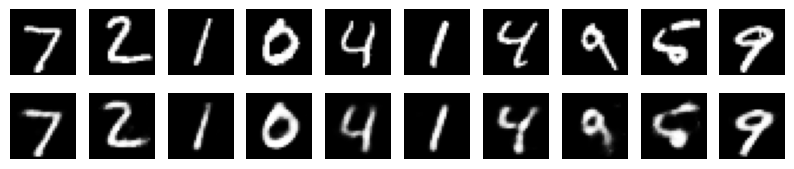

In [ ]:
def visualize_reconstruction(model, loader):
    model.eval()
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)

            inputs = inputs.cpu()
            outputs = outputs.cpu()

            fig, axes = plt.subplots(2, 10, figsize=(10, 2))

            for i in range(10):
                axes[0, i].imshow(inputs[i].view(28, 28), cmap='gray')
                axes[0, i].axis('off')

            for i in range(10):
                axes[1, i].imshow(outputs[i].view(28, 28), cmap='gray')
                axes[1, i].axis('off')

            plt.show()
            break


visualize_reconstruction(autoencoder, testloader)


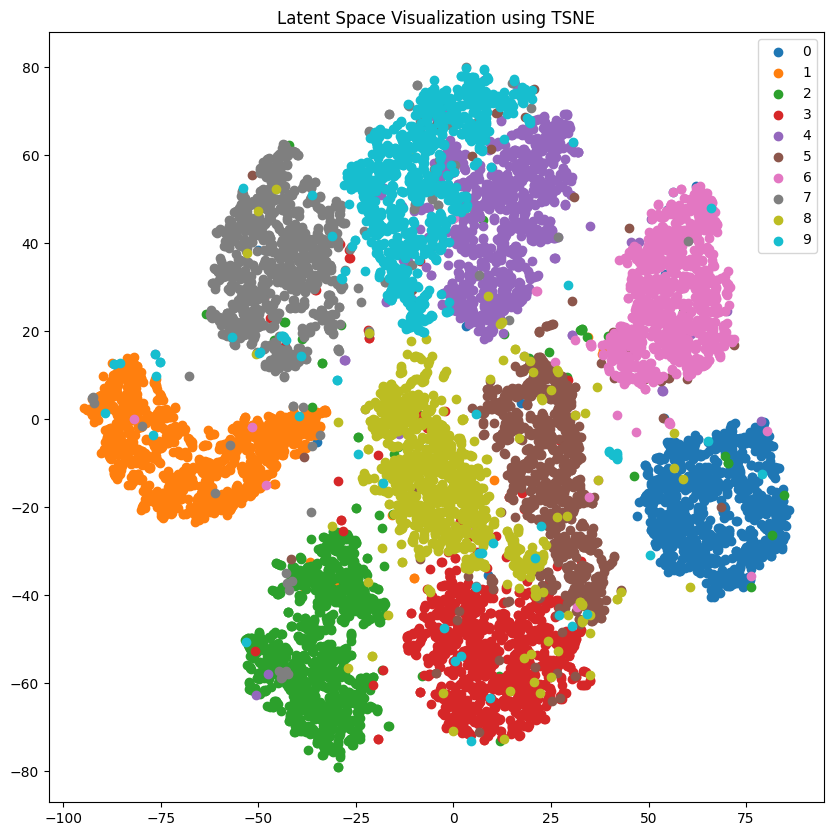

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_latent_space(model, loader, method='tsne'):
    model.eval()
    latent_vectors = []
    labels_list = []

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            encoded = model.encoder(inputs.view(inputs.size(0), -1)).cpu()

            latent_vectors.append(encoded)
            labels_list.append(labels)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels_list = torch.cat(labels_list).numpy()

    if method == 'tsne':
        latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)
    elif method == 'pca':
        latent_2d = PCA(n_components=2).fit_transform(latent_vectors)

    plt.figure(figsize=(10, 10))
    for i in range(10):
        idxs = labels_list == i
        plt.scatter(latent_2d[idxs, 0], latent_2d[idxs, 1], label=str(i))

    plt.legend()
    plt.title(f'Latent Space Visualization using {method.upper()}')
    plt.show()

visualize_latent_space(autoencoder, testloader, method='tsne')


In [ ]:
train_losses = []  # To store training loss for each epoch
val_losses = []    # To store validation loss for each epoch

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    autoencoder.train()  # Set the model to training mode
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Validation step
    autoencoder.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, _ = data
            inputs = inputs.to(device)

            # Forward pass for validation data
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()

    val_loss /= len(testloader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/10], Train Loss: 0.0424, Val Loss: 0.0409
Epoch [2/10], Train Loss: 0.0411, Val Loss: 0.0396
Epoch [3/10], Train Loss: 0.0401, Val Loss: 0.0385
Epoch [4/10], Train Loss: 0.0389, Val Loss: 0.0375
Epoch [5/10], Train Loss: 0.0380, Val Loss: 0.0362
Epoch [6/10], Train Loss: 0.0370, Val Loss: 0.0358
Epoch [7/10], Train Loss: 0.0362, Val Loss: 0.0350
Epoch [8/10], Train Loss: 0.0353, Val Loss: 0.0341
Epoch [9/10], Train Loss: 0.0346, Val Loss: 0.0336
Epoch [10/10], Train Loss: 0.0340, Val Loss: 0.0330


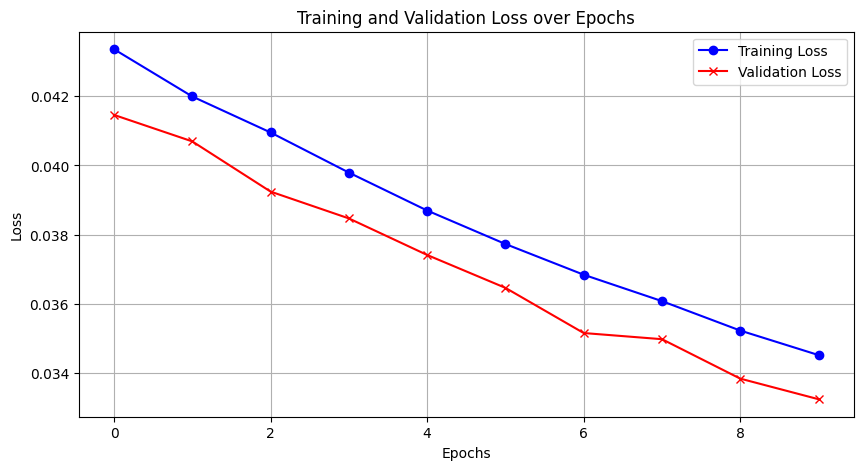

In [ ]:

plot_train_val_losses(train_losses, val_losses)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to visualize latent space after each epoch
def visualize_latent_space_during_training(model, loader, method='tsne', epoch=None):
    model.eval()
    latent_vectors = []
    labels_list = []

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)

            # Use the encoder part of the autoencoder to get latent vectors
            encoded = model.encoder(inputs.view(inputs.size(0), -1)).cpu()

            latent_vectors.append(encoded)
            labels_list.append(labels)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels_list = torch.cat(labels_list).numpy()

    if method == 'tsne':
        latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)
    elif method == 'pca':
        latent_2d = PCA(n_components=2).fit_transform(latent_vectors)

    # Plot latent space after each epoch
    plt.figure(figsize=(10, 10))
    for i in range(10):  # Assuming 10 classes in MNIST dataset (0 to 9)
        idxs = labels_list == i
        plt.scatter(latent_2d[idxs, 0], latent_2d[idxs, 1], label=str(i))

    plt.legend()
    plt.title(f'Latent Space Visualization using {method.upper()} at Epoch {epoch}')
    plt.show()

# Training function with latent space visualization after each epoch
def train_autoencoder_with_visualization(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, method='tsne'):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # Visualize latent space after each epoch
        visualize_latent_space_during_training(model, test_loader, method=method, epoch=epoch+1)

# Define your Autoencoder, DataLoader, optimizer, criterion, etc. before calling this function

# Example usage (assuming you have an autoencoder model and loaders):
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Replace 'autoencoder' with the actual instance of your model and 'train_loader', 'test_loader'
train_autoencoder_with_visualization(autoencoder, train_loader, test_loader, criterion, optimizer, num_epochs=10, method='tsne')


NameError: name 'autoencoder' is not defined